### mRNA Volcano Plots

This notebook serves to generate volcano plots for mRNA gene expression analysis, highlighting genes that belong to significantly altered pathways based on Reactome data.

In [1]:
# Get gene expression file
while True:
    expression_file_name: str = input("Provide gene expression data file (in the CSV format): ")

    if expression_file_name:
        break

if expression_file_name.endswith(".csv") == False:
    expression_file_name = f"{expression_file_name}.csv"

In [2]:
# Get fold change column name
fold_change_column_name_file: str = "fold"
user_input: str = input("Provide fold change column name (default: 'fold'): ")

if user_input:
    fold_change_column_name_file = user_input

In [3]:
# Get p-value column name
p_value_expression_column_name_file: str = "pvalue"
user_input: str = input("Provide p-value column name (default: 'pvalue'): ")

if user_input:
    p_value_expression_column_name_file = user_input

In [4]:
# Get gene name column name
gene_name_column_name_file: str = "gene"
user_input: str = input("Provide gene name column name (default: 'gene'): ")

if user_input:
    gene_name_column_name_file = user_input

In [5]:
# Get pathway file
while True:
    pathway_file_name: str = input("Provide pathway data file (in the CSV format): ")

    if pathway_file_name:
        break

if pathway_file_name.endswith(".csv") == False:
    pathway_file_name = f"{pathway_file_name}.csv"

In [6]:
# Get genes found column name
genes_found_column_name_file: str = "Submitted entities found"
user_input: str = input("Provide genes found in pathway column name (default: 'Submitted entities found'): ")

if user_input:
    genes_found_column_name_file = user_input

In [7]:
# Get p-value column name
p_value_pathway_column_name_file: str = "Entities pValue"
user_input: str = input("Provide p-value column name (default: 'Entities pValue'): ")

if user_input:
    p_value_pathway_column_name_file = user_input

In [8]:
# Get p-value threshold
p_value_pathway_threshold: float = 0.05
user_input: str = input("Provide p-value threshold (default: 0.05): ")

if user_input:
    try:
        p_value_pathway_threshold = float(user_input)
    except:
        pass

In [9]:
# Get the top most changed gene count
top_fc_gene_count: int = 10
user_input: str = input("Provide top most changed (FC) gene count (default: 10): ")

if user_input:
    try:
        top_fc_gene_count = int(user_input)
    except:
        pass

In [10]:
# Get the plot title
plot_title: str = ""

for i in range(3):
    user_input: str = input(f"Provide plot title row {i}: ")

    if user_input:
        plot_title += f"{user_input}"

        if (i < 2):
            plot_title += "\n"


In [11]:
# Read pathway data
import csv

pathway_data: list = []

with open(pathway_file_name, "r") as pathway_file:
    reader = csv.DictReader(pathway_file)

    for row in reader:
        pathway_data.append(row)

In [12]:
significant_label: str = "From significant pathway"
non_significant_label: str = "From non-significant pathway"

def map_color_pathway(pathway_data: list, gene_name: str) -> str:
    # Normalize gene name for case-insensitive comparison
    gene_name_normalized = gene_name.strip().upper()
    
    for pathway in pathway_data:
        if float(pathway[p_value_pathway_column_name_file]) >= p_value_pathway_threshold:
            continue

        genes_in_pathway = pathway[genes_found_column_name_file].split(";")
        # Normalize pathway genes to uppercase for comparison
        genes_normalized = [g.strip().upper() for g in genes_in_pathway]

        if gene_name_normalized in genes_normalized:
            return significant_label
    
    return non_significant_label


In [13]:
import pandas as pd

def count_pathways(df: pd.DataFrame, pathway_data: list, gene_name: str, pathway_significance_column_name: str, gene_name_column: str) -> int:
    
    # Check if gene exists in DataFrame
    gene_rows = df[df[gene_name_column] == gene_name]

    # At this point there should be no empty gene rows
    # if gene_rows.empty:
    #     return 0
    
    is_in_any_significant_pathway: bool = False
    significant_pathway_value: str = gene_rows[pathway_significance_column_name].values[0]
    
    if significant_pathway_value == significant_label:
        is_in_any_significant_pathway = True
    else:
        is_in_any_significant_pathway = False
    
    counter: int = 0
    
    # Normalize gene name for case-insensitive comparison
    gene_name_normalized = gene_name.strip().upper()
    
    for pathway in pathway_data:
        genes_in_pathway = pathway[genes_found_column_name_file].split(";")

        # Normalize pathway genes to uppercase for comparison
        genes_normalized = [g.strip().upper() for g in genes_in_pathway]
        
        # Update the counter only if the gene is in a significant pathway
        if is_in_any_significant_pathway:
            if float(pathway[p_value_pathway_column_name_file]) < p_value_pathway_threshold:
                if gene_name_normalized in genes_normalized:
                    counter += 1
        
        # Don't show pathway counts for gene from non-significant pathways
        #         continue
        # else:
        #     if float(pathway[p_value_pathway_column]) < p_value_pathway_threshold:
        #         continue

        # if gene_name_normalized in genes_normalized:
        #     counter += 1
    
    return counter


In [14]:
# Read and process gene expression data
import math
import pandas as pd

expression_data: list = []

# Remove potential artifacts from Excel export
with open(expression_file_name, "r") as expression_file:
    rows = expression_file.readlines()

    for row in rows:
        stripped_row = row.rstrip(",,,\n")
        stripped_row = f"{stripped_row}\n"
        expression_data.append(stripped_row)

# Save cleaned data to a new file to avoid overwriting the original
cleaned_file_name = expression_file_name.replace(".csv", "_cleaned.csv")
with open(cleaned_file_name, "w") as cleaned_file:
    cleaned_file.writelines(expression_data)

fold_change_column_name: str = "log2(fold change)"
p_value_column_name: str = "p-value"

x_log_fold_change: list = []
y_log_p_value: list = []

df: pd.DataFrame = pd.read_csv(cleaned_file_name)

# Drop rows with missing gene names BEFORE processing
df = df[df[gene_name_column_name_file].notna() & (df[gene_name_column_name_file] != '')]
df = df.reset_index(drop=True)

for index, row in df.iterrows():
    
    raw_fold_change = float(row[fold_change_column_name_file])
    log_fold_change: float = math.log2(raw_fold_change) if raw_fold_change > 0 else -math.log2(-raw_fold_change)
    x_log_fold_change.append(log_fold_change)

    raw_p_value = float(row[p_value_expression_column_name_file])
    log_p_value: float = -1 * math.log10(raw_p_value)
    y_log_p_value.append(log_p_value)

# Add calculated values as columns to the dataframe
df[fold_change_column_name] = x_log_fold_change
df[p_value_column_name] = y_log_p_value

# Add color column based on pathway significance
pathway_significance_column_name: str = "Pathway Significance"
df[pathway_significance_column_name] = df[gene_name_column_name_file].apply(
    lambda gene: map_color_pathway(pathway_data, gene))

# Add size column based on pathway significance
pathway_count_column_name: str = "\nSignificant Pathway Count"
df[pathway_count_column_name] = df[gene_name_column_name_file].apply(
    lambda gene: count_pathways(
        df, pathway_data, gene, pathway_significance_column_name, gene_name_column_name_file))


In [15]:
def get_gene_rows_from_top_pathways(df: pd.DataFrame, pathway_data: list, top_n: int) -> list:
    # Sort pathway data by p-value
    pathway_data_sorted = sorted(pathway_data, key=lambda x: float(x[p_value_pathway_column_name_file]))

    # Get top N pathways
    top_pathways = pathway_data_sorted[:top_n]
    top_significant_pathways: list = []

    for pathway in top_pathways:
        if float(pathway[p_value_pathway_column_name_file]) < p_value_pathway_threshold:
            top_significant_pathways.append(pathway)
    
    genes_in_top_pathways: list = []
        
    for pathway in top_significant_pathways:
        genes = pathway[genes_found_column_name_file].split(";")
        genes_normalized = [g.strip().upper() for g in genes]
        genes_in_top_pathways.append(genes_normalized)

    # Iterate over the dataframe and check if gene is in top pathways
    gene_rows_from_top_pathways: list = []

    for index, row in df.iterrows():
        gene_name_normalized = row[gene_name_column_name_file].strip().upper()

        for genes in genes_in_top_pathways:
            if gene_name_normalized in genes:
                gene_rows_from_top_pathways.append(row)
    
    return gene_rows_from_top_pathways

Text(0.5, 1.0, 'Gene expression\nPSNPs vs Control\nGut')

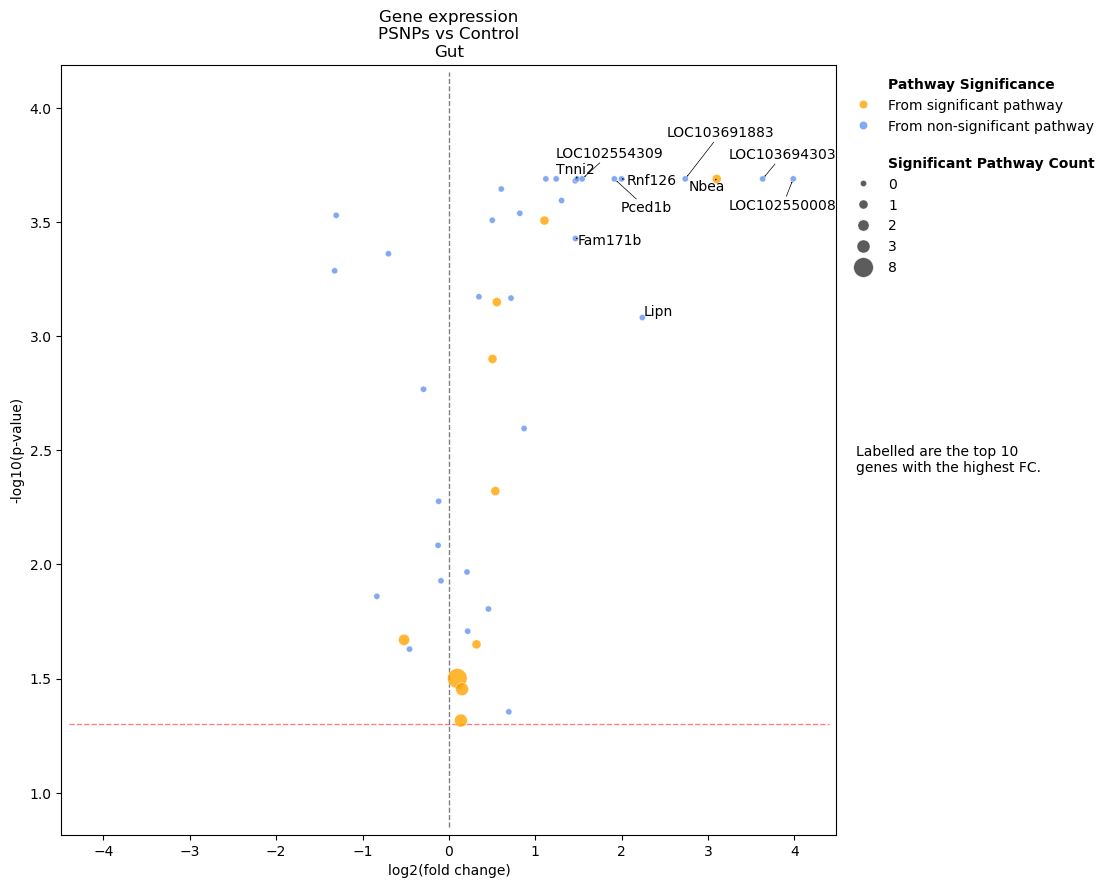

In [ ]:
# Create volcano plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import adjustText

plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x=fold_change_column_name, y=p_value_column_name,
                color='black', alpha=0.8,
                hue=pathway_significance_column_name,
                hue_order=[significant_label, non_significant_label],
                palette=['orange', 'cornflowerblue'],
                size=pathway_count_column_name,
                sizes=(20, 200))
plt.xlabel('log2(fold change)')
plt.ylabel('-log10(p-value)')
plt.axhline(y=-np.log10(0.05), zorder=0, xmin=0.01, xmax=0.99, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=0, zorder=0, ymin=0.01, ymax=0.99, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Set symmetric x-axis limits so 0 is in the center
max_abs_x = max(abs(df[fold_change_column_name].min()), abs(df[fold_change_column_name].max()))
x_margin = 0.5
plt.xlim(-max_abs_x - x_margin, max_abs_x + x_margin)

# Uncomment for vertical margins
# y_margin = 0.5
# plt.ylim(df[p_value_column_name].min() - y_margin, df[p_value_column_name].max() + y_margin)

# Skip labeling genes depending on pathways for now
# Label genes from the most significant pathways
# gene_rows_from_top_pathways: list = get_gene_rows_from_top_pathways(df, pathway_data, top_n=5)

# Remove duplicates by converting to DataFrame and using drop_duplicates
# if gene_rows_from_top_pathways:
#     df_top_pathway_genes = pd.DataFrame(gene_rows_from_top_pathways)
#     df_top_pathway_genes = df_top_pathway_genes.drop_duplicates(subset=[gene_name_column_name_file])
#     gene_rows_from_top_pathways = [row for _, row in df_top_pathway_genes.iterrows()]

# labeled_pathway_genes: list = []

# for i in range(len(gene_rows_from_top_pathways)):
#     labeled_pathway_genes.append(plt.text(x=gene_rows_from_top_pathways[i][fold_change_column_name],
#                          y=gene_rows_from_top_pathways[i][p_value_column_name],
#                          s=gene_rows_from_top_pathways[i][gene_name_column_name_file]))

# adjustText.adjust_text(labeled_pathway_genes, force_text=(0.9,0.9), arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

labeled_fc_genes: list = []
top_fc_indexes = df[fold_change_column_name].abs().nlargest(top_fc_gene_count).index
df_top_fc_genes = df.loc[top_fc_indexes]

for _, row in df_top_fc_genes.iterrows():
    labeled_fc_genes.append(plt.text(x=row[fold_change_column_name],
                         y=row[p_value_column_name],
                         s=row[gene_name_column_name_file]))

adjustText.adjust_text(labeled_fc_genes, force_text=(0.9,0.9), arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Customize legend with bold titles
legend = plt.legend(loc=1, bbox_to_anchor=(1.35, 1), frameon=False)
for text in legend.get_texts():
    if text.get_text() in [pathway_significance_column_name, pathway_count_column_name]:
        text.set_fontweight('bold')

# Extra description under the legend
additional_info = (
    f"Labelled are the top {top_fc_gene_count}\ngenes with the highest absolute FC."
)
plt.gcf().text(0.92, 0.5, additional_info, ha="left", va="top", fontsize=10)

plt.title(plot_title)
